In [ ]:
# Import packages
# !pip install geopandas shapely
# !pip install --upgrade plotnine
from plotnine import ggplot, aes, geom_sf, ggtitle, scale_fill_viridis
import pandas as pd
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load data (at start of session)
file_path = "/content/drive/My Drive/uk_datacentermap.csv"
uk_df = pd.read_csv(file_path)

shp_path = "/content/drive/My Drive/gadm41_GBR_1.shp"
uk_shape = gpd.read_file(shp_path)

In [ ]:
# Find CSV
file_path = '/content/drive/My Drive/datacentermap.csv'

# Read CSV
df = pd.read_csv(file_path, header=0, quotechar='"', escapechar='\\')

# Preview
df.head()

,name,id,parent_id,company_name,company_id,stage,type,latitude,longitude,address,postal,city,market,state,country,power_mw,pue,year_operational
0,00gate,6583,0.0,Exe.it Srl Sb,5509,Operational,Colocation,44.410238,11.588703,"Via Meucci, 24/i/2",40024,Castel San Pietro Terme,Castel San Pietro Terme,NaN,Italy,NaN,NaN,NaN
1,1000 Coit Road,11653,0.0,Lincoln Rackhouse,5113,Operational,Colocation,33.015023,-96.764808,1000 Coit Rd,75075,Plano,Dallas,Texas,USA,NaN,NaN,NaN
2,1001 Texas Data Center,8680,0.0,1001 Texas Data Center,10533,Operational,Colocation,29.760061,-95.362102,1001 Texas Ave,77002,Houston,Houston,Texas,USA,4.0,NaN,2000.0
3,10051 Brickyard Wy,11089,0.0,Digital Realty,419,Under Construction,Colocation,38.736918,-77.507827,10051 Brickyard Wy,20110,Manassas,Manassas,Virginia,USA,NaN,NaN,NaN
4,100 Gough Road,14007,0.0,BentallGreenOak (BGO),12902,Operational,Colocation,43.837376,-79.325671,100 Gough Road,L3R 4B7,Markham,Toronto,NaN,Canada,12.0,NaN,NaN


In [ ]:
# Filter for UK data centres
uk_df = df[df['country'] == 'United Kingdom']

# Filter by those that are currently operational
uk_operational_df = uk_df[uk_df['stage'].str.strip().str.lower() == 'operational']

# Save
# save_path = "/content/drive/My Drive/uk_datacentermap.csv"
# uk_df.to_csv(save_path, index=False)

In [ ]:
# Convert to GeoDataFrame
gdf_points = gpd.GeoDataFrame(
    uk_operational_df,
    geometry=gpd.points_from_xy(uk_operational_df['longitude'], uk_operational_df['latitude']),
    crs="EPSG:4326"
)

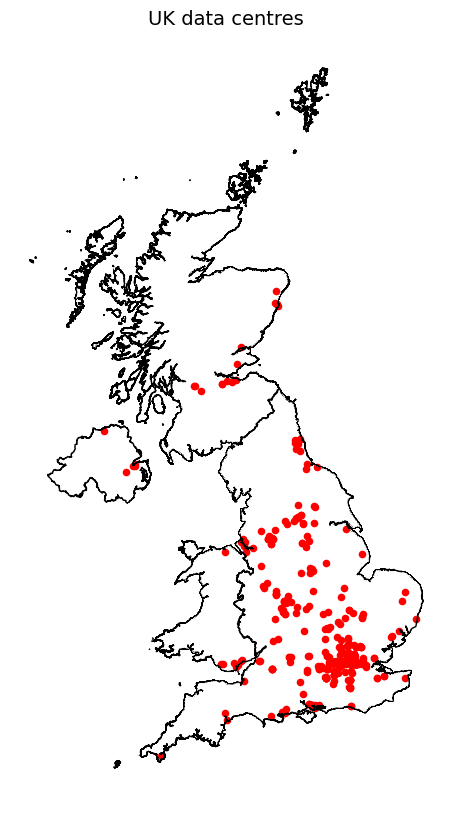

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(8, 10))
uk_shape.boundary.plot(ax=ax, color="black", linewidth=1)
gdf_points.plot(ax=ax, color="red", markersize=20)
ax.set_axis_off()

plt.title("UK data centres", fontsize=14)
plt.show()

In [ ]:
# Local data
local_path = "/content/drive/My Drive/LAD_MAY_2024_UK_BFE.shp"
local_shape = gpd.read_file(local_path)
local_shape = local_shape.rename(columns={'LAD24CD': 'ladcode23', 'LAD24NM': 'laname23'})

local_shape.head()

,ladcode23,laname23,LAD24NMW,BNG_E,BNG_N,LONG,LAT,geometry
0,E06000001,Hartlepool,None,447161,531473,-1.27017,54.6761,"POLYGON ((447213.9 537036.104, 447228.798 5370..."
1,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.5447,"POLYGON ((448489.897 522071.798, 448592.597 52..."
2,E06000003,Redcar and Cleveland,None,464330,519596,-1.00656,54.5675,"POLYGON ((455553.038 528401.602, 455732.806 52..."
3,E06000004,Stockton-on-Tees,None,444940,518179,-1.30664,54.5569,"POLYGON ((444157.002 527956.304, 444165.898 52..."
4,E06000005,Darlington,None,428029,515648,-1.56835,54.5353,"POLYGON ((423496.602 524724.299, 423497.204 52..."


In [ ]:
# Create merged employment - population - spatail dataset
# Load employment data
file_path = '/content/drive/MyDrive/employmentlasewcensus2021.xlsx'
df = pd.read_excel(file_path)

# Load population data
file_path1 = '/content/drive/MyDrive/pop.csv'
pop = pd.read_csv(file_path1)

# Filter
filtered_df = df[df['Subgroup'] == 'Total population']

# Merge
merged_df = pd.merge(filtered_df, pop, on='ladcode23')

# Clean
merged_df = merged_df.drop(columns=['Local authority district', 'Subgroup', 'Percentage estimate', 'laname23'])

# Merge again
sf_employment = pd.merge(merged_df, local_shape, on='ladcode23')

# Clean again
sf_employment = sf_employment.drop(columns=['LAD24NMW', 'BNG_E', 'BNG_N'])

# Pivot data
id_vars = [col for col in sf_employment.columns if col not in ['Economic activity', 'Population estimate']]

employment_pivot = sf_employment.pivot_table(
    index=id_vars,
    columns='Economic activity',
    values='Population estimate'
).reset_index()

# Clean
employment_pivot.columns.name = None
employment_pivot = employment_pivot.rename(columns={
    'Active': 'Employed',
    'Inactive': 'Unemployed'
})

# Convert GeoDataFrame
sf_employment_wide = gpd.GeoDataFrame(
    employment_pivot,
    geometry='geometry',
    crs="EPSG:4326"
)

# Calculate employed/unemployed per 1,000 people
cols_to_convert = ['Employed', 'Unemployed', 'population']

# Loop through each column to clean and convert it
for col in cols_to_convert:
    sf_employment_wide[col] = pd.to_numeric(
        sf_employment_wide[col].astype(str).str.replace(',', ''),
        errors='coerce'
    )

sf_employment_wide['employed_1000'] = (sf_employment_wide['Employed'] / sf_employment_wide['population']) * 1000
sf_employment_wide['unemployed_1000'] = (sf_employment_wide['Unemployed'] / sf_employment_wide['population']) * 1000

# Save
folder_path = '/content/drive/MyDrive/'
output_file_path = os.path.join(folder_path, 'uk_employment_data.gpkg')
sf_employment_wide.to_file(output_file_path, driver='GPKG')

,Economic activity,ladcode23,Population estimate,population
0,Active,E06000001,40750,"92,575"
1,Inactive,E06000001,33935,"92,575"
2,Active,E06000002,62250,"143,943"
3,Inactive,E06000002,51690,"143,943"
4,Active,E06000003,59625,"136,605"


In [ ]:
gdf = gpd.read_file(file_path)

choropleth_map = (
        ggplot(gdf) +
        geom_sf(aes(fill='unemployed_1000')) +
        scale_fill_viridis(name='Unemployed per 1000', direction=-1) +
        ggtitle('Unemployment Rate by Local Authority')
    )

# Display the map
print(choropleth_map)